In [12]:
from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms
from create_context import create_context_batch

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import random
import pandas as pd
import time

from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cpu


# Data loading and Preprocess

In [13]:
# voc dataset directory
train_dir =r'../datasets/VOCtrainval/VOC2012'
train_image_dir = train_dir + r'/JPEGImages'
train_bb_anno_dir = train_dir + r'/Annotations'
train_anno_dir = train_dir + r'/ImageSets/Action'

val_dir =r'../datasets/VOCtrainval/VOC2012'
val_image_dir = val_dir + r'/JPEGImages'
val_bb_anno_dir = val_dir + r'/Annotations'
val_anno_dir = val_dir + r'/ImageSets/Action'

test_dir =r'../datasets/VOCtest/VOC2012'
test_image_dir = test_dir + r'/JPEGImages'
test_bb_anno_dir = test_dir + r'/Annotations'
test_anno_dir = test_dir + r'/ImageSets/Action'

# gaze dataset directory
gaze_dir = r'../datasets/gaze_voc_actions/samples'
geometry_file = r'../datasets/gaze_voc_actions/geometry.txt'

image_id = '2010_006174'

In [14]:
# load the bounding box 
import xml.etree.ElementTree as ET
def load_bbox(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
#     filename = root.find('filename').text

    for boxes in root.iter('object'):
        
#         only consider the bounding box of human
        if boxes.find("name").text!="person":
            continue

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = float(box.find("ymin").text)
            xmin = float(box.find("xmin").text)
            ymax = float(box.find("ymax").text)
            xmax = float(box.find("xmax").text)
            
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes


In [15]:
# helper funtion for data loading
def load_image_ids(filename):
    with open(filename) as f:
        ids = f.read().split()
    return ids

# action_labels = ['phoning', 'playinginstrument', 'reading', 
#                  'ridingbike','ridinghorse', 'running', 
#                  'takingphoto','usingcomputer', 'walking',
#                  'jumping','other']

action_labels = ['phoning', 'playinginstrument', 'reading', 
                 'ridingbike','ridinghorse', 'running', 
                 'takingphoto','usingcomputer', 'walking',
                 'jumping']


def load_labels(filename, action_id, 
                person_id_to_image_id={},
                image_id_to_person_id={},
                labels=[]):

    with open(filename) as f:
        for i,line in enumerate(f.readlines()):
            linestr = line.strip()
            linestrlist = linestr.split()
            iid = (linestrlist[0],int(linestrlist[1]))
            if iid not in image_id_to_person_id:
                pid = len(image_id_to_person_id)
                image_id_to_person_id[iid] = pid
                person_id_to_image_id[pid] = iid
                labels.append([0]*len(action_labels))
            else:
                pid = image_id_to_person_id[iid]
            
            labels[pid][action_id]=int(linestrlist[2])==1


In [16]:
# Load annotations file for the training images.
train_p2i={}
train_i2p={}
train_labels=[]
for action_id, action_label in enumerate(action_labels[:]):
    train_action_file = train_anno_dir + '/' + action_label + '_train.txt'
    load_labels(train_action_file, action_id,
                train_p2i,train_i2p,
                train_labels)

# # make the 'other' class label
# for pid in range(len(train_labels)):
#     train_labels[pid][-1]=(sum(train_labels[pid])==0)
        
        
train_file_ids = load_image_ids(train_anno_dir + '/train.txt')
train_bboxes = [[0]*4]*len(train_labels)
for image_id in train_file_ids:
    try:
        boxes = load_bbox(train_bb_anno_dir+'/'+image_id+'.xml')
    except:
        print(image_id)
    for i,bbox in enumerate(boxes):
        iid = (image_id,i+1)
        train_bboxes[train_i2p[iid]] = bbox
print('%d people in %d images loaded'%(len(train_labels),len(train_file_ids)))

train_id_to_file = {train_id: train_image_dir+'/'+ train_id + '.jpg' 
                    for train_id in train_file_ids}


3134 people in 2296 images loaded


In [17]:
# Load annotations file for the validation images.
val_p2i={}
val_i2p={}
val_labels=[]
for action_id, action_label in enumerate(action_labels[:]):
    val_action_file = val_anno_dir + '/' + action_label + '_val.txt'
    load_labels(val_action_file, action_id,
                val_p2i,val_i2p,
                val_labels)
    
# # make the 'other' class label
# for pid in range(len(val_labels)):
#     val_labels[pid][-1]=(sum(val_labels[pid])==0)
    
val_file_ids = load_image_ids(val_anno_dir + '/val.txt')
val_bboxes = [[0]*4]*len(val_labels)
for image_id in val_file_ids:
    try:
        boxes = load_bbox(val_bb_anno_dir+'/'+image_id+'.xml')
    except:
        print(image_id)
    for i,bbox in enumerate(boxes):
        iid = (image_id,i+1)
        val_bboxes[val_i2p[iid]] = bbox
print('%d people in %d images loaded'%(len(val_labels),len(val_file_ids)))

val_id_to_file = {val_id: val_image_dir+'/'+ val_id + '.jpg' 
                    for val_id in val_file_ids}

3144 people in 2292 images loaded


In [18]:
# Load annotations file for the validation images.
test_p2i={}
test_i2p={}
test_labels=[]
for action_id, action_label in enumerate(action_labels[:-1]):
    test_action_file = test_anno_dir + '/' + action_label + '_test.txt'
    load_labels(test_action_file, action_id,
                test_p2i,test_i2p,
                test_labels)

    
test_file_ids = load_image_ids(test_anno_dir + '/test.txt')
test_bboxes = [[0]*4]*len(test_labels)
for image_id in test_file_ids:
    try:
        boxes = load_bbox(test_bb_anno_dir+'/'+image_id+'.xml')
    except:
        print(image_id)
    for i,bbox in enumerate(boxes):
        iid = (image_id,i+1)
        test_bboxes[test_i2p[iid]] = bbox
print('%d people in %d images loaded'%(len(test_labels),len(test_file_ids)))

test_id_to_file = {test_id: test_image_dir+'/'+ test_id + '.jpg' 
                    for test_id in test_file_ids}

6283 people in 4569 images loaded


In [19]:
def gen_im_labels(image_id_to_person_id, label_p, im_num, mode="single_action"):
    label_i_npa = np.zeros((im_num,len(label_p[0])))
#     print(label_i_npa.shape)
    im_count=0
    idx_2_imid={}
    imid_2_idx={}
    for i2p in image_id_to_person_id:
        if i2p[1]==1:
            idx_2_imid[im_count]=i2p[0]
            imid_2_idx[i2p[0]]=im_count
            im_count=im_count+1
        label_i_npa[imid_2_idx[i2p[0]]] = label_i_npa[imid_2_idx[i2p[0]]] +\
                                            np.asanyarray(label_p[image_id_to_person_id[i2p]])

#     print(np.sum(label_i_npa))
#     t=np.sum(label_i_npa,axis=1)
#     for i,tt in enumerate(t):
#         if tt==0:
#             print(i,idx_2_imid[i])
#             display.display(display.Image(train_id_to_file[idx_2_imid[i]]))
    label_i_npa=(label_i_npa>0).astype(int)
    
    # remove multi-label samples
    if mode=="single_action":
        im_count = 0
        idx_2_imid_sa={}
        imid_2_idx_sa={}
        single_action_indices= np.sum(label_i_npa, axis=1) == 1
        label_i_npa_sa = label_i_npa[single_action_indices, :]
        for i in range(label_i_npa.shape[0]):
            if single_action_indices[i]:
                idx_2_imid_sa[im_count] = idx_2_imid[i]
                imid_2_idx_sa[idx_2_imid[i]] = im_count
                im_count = im_count+1
                
        return idx_2_imid_sa, imid_2_idx_sa, label_i_npa_sa
                
    else:
        return idx_2_imid, imid_2_idx, label_i_npa



train_idx_to_imid, train_imid_to_idx, train_labels_npa = \
    gen_im_labels(train_i2p, train_labels,len(train_file_ids))
# train_idx_to_imid, train_imid_to_idx, train_labels_npa = \
#     gen_im_labels(train_i2p, train_labels,len(train_file_ids),"all")
print('%d actions in %d training images generated'%(np.sum(train_labels_npa),
                                           train_labels_npa.shape[0]))

val_idx_to_imid, val_imid_to_idx, val_labels_npa = \
    gen_im_labels(val_i2p, val_labels,len(val_file_ids))
# val_idx_to_imid, val_imid_to_idx, val_labels_npa = \
#     gen_im_labels(val_i2p, val_labels,len(val_file_ids),"all")
print('%d actions in %d validation images generated'%(np.sum(val_labels_npa),
                                           val_labels_npa.shape[0]))

test_idx_to_imid, test_imid_to_idx, test_labels_npa = \
    gen_im_labels(test_i2p, test_labels,len(test_file_ids),"all")
print('%d actions in %d test images generated'%(np.sum(test_labels_npa),
                                           test_labels_npa.shape[0]))

1865 actions in 1865 training images generated
1848 actions in 1848 validation images generated
0 actions in 4569 test images generated


In [20]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
def load_image(filename, bbox=None, volatile=False):
    """
    Simple function to load and preprocess the image.
    0. define the loader
    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    
    if bbox:
        image = Image.open(filename).convert('RGB').crop(bbox)
    else:
        image = Image.open(filename).convert('RGB')
        
#     image.show()
    loader = transforms.Compose([
      transforms.Resize((img_size,img_size)),
#       transforms.CenterCrop(img_size),
      transforms.ToTensor(),
    ]) 
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    return image_var.to(device)


2012_003447 1685
Action of the image(2012_003447):  ['ridinghorse']


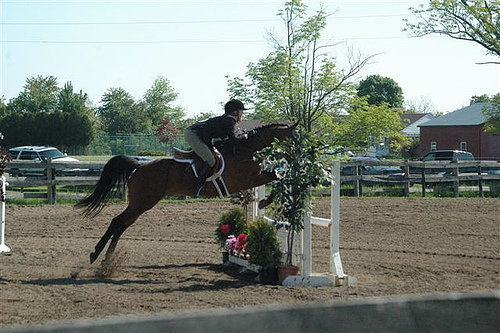

('2012_003447', 1) [183.0, 100.0, 252.0, 201.0]
Action of cropped person:  ['ridinghorse']


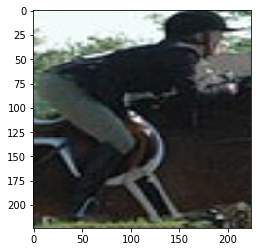

In [21]:
pid = random.randint(0,len(train_labels))

im_id = train_p2i[pid][0]

if im_id in train_imid_to_idx:
    im_idx = train_imid_to_idx[im_id]
    print(im_id, im_idx)
    print("Action of the image(%s): "%(im_id),[action_labels[i] for i,a in enumerate(train_labels_npa[im_idx]) if a])

display.display(display.Image(train_id_to_file[im_id]))
img = load_image(train_id_to_file[im_id],train_bboxes[pid])
img_array = np.moveaxis(img.squeeze().detach().cpu().numpy(),0,-1)
    
print(train_p2i[pid],train_bboxes[pid])
print("Action of cropped person: ",[action_labels[i] for i,a in enumerate(train_labels[pid]) if a])
matplotlib.pyplot.imshow(img_array)

In [24]:
print(action_labels)
print(np.sum(train_labels_npa,0),train_labels_npa.shape[0])
print(np.sum(val_labels_npa,0),val_labels_npa.shape[0])

['phoning', 'playinginstrument', 'reading', 'ridingbike', 'ridinghorse', 'running', 'takingphoto', 'usingcomputer', 'walking', 'jumping']
[207 218 223 173 191 143 190 191 146 183] 1865
[205 215 219 170 191 139 188 188 150 183] 1848


# Feature Extraction

In [22]:
# def the ResNet feature extractor
resnet_model = models.resnet50(pretrained=True)
# resnet_model = models.resnet101(pretrained=True)
resnet_model = resnet_model.to(device)
resnet_model.eval()

# cut off one layer
feature_extractor = nn.Sequential(*list(resnet_model.children())[:-1])
# cut off two layers
image_feature_extractor = nn.Sequential(*list(resnet_model.children())[:-2])

In [12]:
# load image extract the features
if os.path.exists('outputs/training_vectors') and os.path.exists('outputs/image_training_vectors'):
    training_vectors = np.load('outputs/training_vectors')
    image_training_vectors = np.load('outputs/image_training_vectors')
    print("training_vectors loaded.")    
else:
    training_vectors = np.zeros((train_labels_npa.shape[0], 2048))
    image_training_vectors = np.zeros((train_labels_npa.shape[0], 2048, 7, 7))
    for i, im_idx in tqdm(enumerate(train_idx_to_imid)):
        # Load/preprocess the image.
        iid = train_idx_to_imid[im_idx]
        
        # extract the feature of the image
        img_o = load_image(train_id_to_file[iid])
        image_features_output = image_feature_extractor(img_o).squeeze()
        image_training_vectors[i,:,:,:] = image_features_output.cpu().detach().numpy()
        
        features_output = feature_extractor(img_o).squeeze()
        training_vectors[i,:] = features_output.cpu().detach().numpy()
        
    #  save the feature matrix
    np.save(open('outputs/training_vectors', 'wb+'), training_vectors)
    np.save(open('outputs/image_training_vectors', 'wb+'), image_training_vectors)
    print("training_vectors saved.")

training_vectors loaded.


In [13]:
# load image extract the features
if os.path.exists('outputs/validation_vectors') and os.path.exists('outputs/image_validation_vectors'):
    validation_vectors = np.load('outputs/validation_vectors')
    image_validation_vectors = np.load('outputs/image_validation_vectors')
    print("validation_vectors loaded.")    
else:
    validation_vectors=np.zeros((val_labels_npa.shape[0], 2048))
    image_validation_vectors = np.zeros((val_labels_npa.shape[0], 2048, 7, 7))
    for i, im_idx in tqdm(enumerate(val_idx_to_imid)):
        # Load/preprocess the image.
        iid = val_idx_to_imid[im_idx]
        
        # extract the feature of the image
        img_o = load_image(val_id_to_file[iid])
        image_features_output = image_feature_extractor(img_o).squeeze()
        image_validation_vectors[i,:,:,:] = image_features_output.cpu().detach().numpy()
        
        features_output =feature_extractor(img_o).squeeze()
        validation_vectors[i,:] = features_output.cpu().detach().numpy()

    #  save the feature matrix
    np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)
    np.save(open('outputs/image_validation_vectors', 'wb+'), image_validation_vectors)
    print("validation_vectors saved.")


validation_vectors loaded.


In [14]:
# load image extract the features
if os.path.exists('outputs/test_vectors') and os.path.exists('outputs/image_test_vectors'):
    test_vectors = np.load('outputs/test_vectors')
    image_test_vectors = np.load('outputs/image_test_vectors')
    print("test_vectors loaded.")    
else:
    test_vectors=np.zeros((test_labels_npa.shape[0], 2048))
    image_test_vectors = np.zeros((test_labels_npa.shape[0], 2048, 7, 7))
    for i, im_idx in tqdm(enumerate(test_idx_to_imid)):
        # Load/preprocess the image.
        iid = test_idx_to_imid[im_idx]
        
        # extract the feature of the image
        img_o = load_image(test_id_to_file[iid])
        image_features_output = image_feature_extractor(img_o).squeeze()
        image_test_vectors[i,:,:,:] = image_features_output.cpu().detach().numpy()
        
        features_output =feature_extractor(img_o).squeeze()
        test_vectors[i,:] = features_output.cpu().detach().numpy()

    #  save the feature matrix
    np.save(open('outputs/test_vectors', 'wb+'), test_vectors)
    np.save(open('outputs/image_test_vectors', 'wb+'), image_test_vectors)
    print("test_vectors saved.")


test_vectors loaded.


# Get gazemaps for each image and create context vectors (takes a few mins)

In [15]:
from gaze_heat import create_gaze_map
from scipy.misc import imresize
from scipy.special import softmax

# Load screen geometry
geometry = np.genfromtxt(geometry_file, delimiter='\t')
screen = geometry[3:5]

# load image extract the features
if os.path.exists('outputs/all_gaze_training') and\
        os.path.exists('outputs/all_gaze_validation') and\
        os.path.exists('outputs/all_train_labels_npa') and\
        os.path.exists('outputs/all_val_labels_npa')and\
        os.path.exists('outputs/train_gaze_maps')and\
        os.path.exists('outputs/val_gaze_maps'):
    all_gaze_training = np.load('outputs/all_gaze_training')
    all_gaze_validation = np.load('outputs/all_gaze_validation')
    all_train_labels_npa = np.load('outputs/all_train_labels_npa')
    all_val_labels_npa = np.load('outputs/all_val_labels_npa')
    train_gaze_maps = np.load('outputs/train_gaze_maps')
    val_gaze_maps = np.load('outputs/val_gaze_maps')
    print("All gaze data and labels loaded.")    
else:

    all_gaze_training = np.empty((0,4096), float)
    all_gaze_validation = np.empty((0,4096), float)

    all_train_labels_npa = np.empty((0,len(action_labels)), int)
    all_val_labels_npa = np.empty((0,len(action_labels)), int)

    # subjects = ['006_', '007_', '008_', '009_', '010_', '011_', '015_', '017_', '018_', '020_', '021_', '022_']
    subjects = ['006_']

    for subject in tqdm(subjects):

        train_flag = np.ones(train_labels_npa.shape[0], dtype=bool)
        val_flag = np.ones(val_labels_npa.shape[0], dtype=bool)

        train_gaze_maps = np.zeros((train_labels_npa.shape[0], 7, 7))
        for p, im_idx in tqdm(enumerate(train_idx_to_imid)):

            # Load/preprocess the image.
            iid = train_idx_to_imid[im_idx]
            img = plt.imread(train_id_to_file[iid])
            
            # Load gaze data, get X,Y eye position
            exists = os.path.isfile(os.path.join(gaze_dir, subject + iid + '.jpg.txt'))
            if exists:
                gaze_data = pd.read_csv(os.path.join(gaze_dir, subject + iid + '.jpg.txt'), delim_whitespace=True, header=None)
            else:
                # Use data from subject '006_ as dummy'
                gaze_data = pd.read_csv(os.path.join(gaze_dir, '006_' + iid + '.jpg.txt'), delim_whitespace=True, header=None)
                train_flag[p] = False
            # filter S or F
            gaze_data = gaze_data.loc[gaze_data[5] == "F"]
            gaze = gaze_data.values[100:, 3:5]
            gaze = gaze.astype(float)    

            # Create gaze heat map
            gaze_map = create_gaze_map(img, gaze, screen, plot=False)            
            train_gaze_maps[p, :, :] = np.array(Image.fromarray(gaze_map).resize((7, 7)))

        val_gaze_maps = np.zeros((val_labels_npa.shape[0], 7, 7))
        for p, im_idx in tqdm(enumerate(val_idx_to_imid)):

            # Load/preprocess the image.
            iid = val_idx_to_imid[im_idx]
            img = plt.imread(val_id_to_file[iid])
            
            # Load gaze data, get X,Y eye position
            exists = os.path.isfile(os.path.join(gaze_dir, subject + iid + '.jpg.txt'))
            if exists:
                gaze_data = pd.read_csv(os.path.join(gaze_dir, subject + iid + '.jpg.txt'), delim_whitespace=True, header=None)
            else:
                # Use data from subject '006_ as dummy'
                gaze_data = pd.read_csv(os.path.join(gaze_dir, '006_' + iid + '.jpg.txt'), delim_whitespace=True, header=None)
                val_flag[p] = False
            # filter S or F
            gaze_data = gaze_data.loc[gaze_data[5] == "F"]
            gaze = gaze_data.values[100:, 3:5]
            gaze = gaze.astype(float)   

            # Create gaze heat map
            gaze_map = create_gaze_map(img, gaze, screen, plot=False)
            val_gaze_maps[p, :, :] = np.array(Image.fromarray(gaze_map).resize((7, 7)))

        # Create context vectors
        training_contexts = np.zeros((train_labels_npa.shape[0], 2048))
        for p in range(train_labels_npa.shape[0]):
            for i in range(7):
                for j in range(7):
                    training_contexts[p, :] += train_gaze_maps[p, i, j] * image_training_vectors[p, :, i, j]

        val_contexts = np.zeros((val_labels_npa.shape[0], 2048))
        for p in range(val_labels_npa.shape[0]):
            for i in range(7):
                for j in range(7):
                    val_contexts[p, :] += val_gaze_maps[p, i, j] * image_validation_vectors[p, :, i, j]            

        # concat training vectors with context
        gaze_training_vectors = np.hstack((training_vectors, training_contexts))
        gaze_validation_vectors = np.hstack((validation_vectors, val_contexts))

        # remove flagged lines
        gaze_training_vectors = gaze_training_vectors[train_flag]
        gaze_validation_vectors = gaze_validation_vectors[val_flag]

        train_labels_npa_tmp = train_labels_npa[train_flag]
        val_labels_npa_tmp = val_labels_npa[val_flag]

        # and stack 
        all_gaze_training = np.vstack((all_gaze_training, gaze_training_vectors))
        all_gaze_validation = np.vstack((all_gaze_validation, gaze_validation_vectors))

        all_train_labels_npa = np.vstack((all_train_labels_npa, train_labels_npa_tmp))  
        all_val_labels_npa = np.vstack((all_val_labels_npa, val_labels_npa_tmp))                  

    #  save all these
    np.save(open('outputs/all_gaze_training', 'wb+'), all_gaze_training)
    np.save(open('outputs/all_gaze_validation', 'wb+'), all_gaze_validation)
    np.save(open('outputs/all_train_labels_npa', 'wb+'), all_train_labels_npa)
    np.save(open('outputs/all_val_labels_npa', 'wb+'), all_val_labels_npa)
    np.save(open('outputs/val_gaze_maps', 'wb+'), val_gaze_maps)
    np.save(open('outputs/train_gaze_maps', 'wb+'), train_gaze_maps)
    print("All gaze data and labels saved.")


All gaze data and labels loaded.


In [16]:
# load image extract the features
if os.path.exists('outputs/all_gaze_test')and\
        os.path.exists('outputs/test_gaze_maps'):
    test_gaze_maps = np.load('outputs/test_gaze_maps')
    all_gaze_test = np.load('outputs/all_gaze_test')
    print("Test gaze data and labels loaded.")    
else:

    all_gaze_test = np.empty((0,4096), float)
    all_test_labels_npa = np.empty((0,len(action_labels)), int)

    # subjects = ['006_', '007_', '008_', '009_', '010_', '011_', '015_', '017_', '018_', '020_', '021_', '022_']
    # using subject 008 because some samples from 006 are missing 
    subjects = ['008_']

    for subject in tqdm(subjects):

        test_flag = np.ones(test_labels_npa.shape[0], dtype=bool)

        test_gaze_maps = np.zeros((test_labels_npa.shape[0], 7, 7))
        for p, im_idx in tqdm(enumerate(test_idx_to_imid)):

            # Load/preprocess the image.
            iid = test_idx_to_imid[im_idx]
            img = plt.imread(test_id_to_file[iid])
            
            # Load gaze data, get X,Y eye position
            exists = os.path.isfile(os.path.join(gaze_dir, subject + iid + '.jpg.txt'))
            if exists:
                gaze_data = pd.read_csv(os.path.join(gaze_dir, subject + iid + '.jpg.txt'), delim_whitespace=True, header=None)
            else:
                # Use data from subject '006_ as dummy'
                gaze_data = pd.read_csv(os.path.join(gaze_dir, '006_' + iid + '.jpg.txt'), delim_whitespace=True, header=None)
                test_flag[p] = False
            # filter S or F
            gaze_data = gaze_data.loc[gaze_data[5] == "F"]
            gaze = gaze_data.values[100:, 3:5]
            gaze = gaze.astype(float)   

            # Create gaze heat map
            gaze_map = create_gaze_map(img, gaze, screen, plot=False)
            test_gaze_maps[p, :, :] = np.array(Image.fromarray(gaze_map).resize((7, 7)))

        # Create context vectors

        test_contexts = np.zeros((test_labels_npa.shape[0], 2048))
        for p in range(test_labels_npa.shape[0]):
            for i in range(7):
                for j in range(7):
                    test_contexts[p, :] += test_gaze_maps[p, i, j] * image_test_vectors[p, :, i, j]            

        # concat training vectors with context
        gaze_test_vectors = np.hstack((test_vectors, test_contexts))

        # remove flagged lines
        gaze_test_vectors = gaze_test_vectors[test_flag]

        # and stack 
        all_gaze_test = np.vstack((all_gaze_test, gaze_test_vectors))
               

    #  save all these
    np.save(open('outputs/test_gaze_maps', 'wb+'), test_gaze_maps)
    np.save(open('outputs/all_gaze_test', 'wb+'), all_gaze_test)
    print("Test gaze data saved.")


Test gaze data and labels loaded.


# Training classifiers
## Multilabel Classification with SVM 

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# SVM with linear kernel overfits the training set and the performance of other ones is not satisfying
# kernel_type = 'linear'
# kernel_type = 'poly'
kernel_type = 'rbf'
classifier = OneVsRestClassifier(SVC(kernel=kernel_type, gamma='scale'))
gaze_classifier = OneVsRestClassifier(SVC(kernel=kernel_type, gamma='scale'))

# Train without gaze data
start = time.time()
classifier.fit(training_vectors, train_labels_npa)
print("WITHOUT GAZE - " + str(classifier.score(training_vectors, train_labels_npa)))
end = time.time()
print(' --- training time - %d seconds' % (end - start))

# Train with gaze data
start = time.time()
gaze_classifier.fit(all_gaze_training, all_train_labels_npa)
print("WITH GAZE - " + str(gaze_classifier.score(all_gaze_training, all_train_labels_npa)))
end = time.time()
print(' --- training time - %d seconds' % (end - start))

WITHOUT GAZE - 0.6305630026809651
 --- training time - 41 seconds
WITH GAZE - 0.6080428954423592
 --- training time - 85 seconds


In [21]:
predictions = classifier.predict(validation_vectors)
print(sum(predictions), sum(val_labels_npa))
print("WITHOUT GAZE - " + str(classifier.score(validation_vectors, val_labels_npa)))

#gaze_validation_vectors = np.hstack((validation_vectors, val_contexts))
gaze_predictions = gaze_classifier.predict(all_gaze_validation)
print(sum(gaze_predictions), sum(all_val_labels_npa))
print("WITH GAZE - " + str(gaze_classifier.score(all_gaze_validation, all_val_labels_npa)))

[ 77 147  76 126 145  67  41 134   0 105] [205 215 219 170 191 139 188 188 150 183]
WITHOUT GAZE - 0.44642857142857145
[108 144  71 124 129  59  50 111   1 105] [205 215 219 170 191 139 188 188 150 183]
WITH GAZE - 0.43614718614718617


## Multilabel classification with NN

In [17]:
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        When constructing the model, we initialize two linear modules and assign them
        as class fields.
        """
        super(MultiLabelClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.fully_connected = nn.Linear(2048, 1)
        
        self.att = nn.Conv2d(2048, 1, 1)
        self.attfc = nn.Linear(49,49)
    
    def forward(self, x):
        """
        Pass the input through the network, applying the sigmoid activation function after each layer.
        """
        return self.layer2(torch.sigmoid(self.layer1(x)))
    
    def attention(self, x):
        return self.fully_connected(x)
    def attention2(self, x):
        return self.attfc(self.att(x.view(1,-1,1,1)))


In [70]:
# Randomize training vectors
# training_vectors = np.random.random((len(train_ids), 4096))

# Now we prepare the input data, by converting the generated vectors into PyTorch variables.
training_input = [Variable(torch.FloatTensor(train_vector)).to(device) for train_vector,train_id in zip(training_vectors,range(len(train_labels))) ]
gaze_training_input = [Variable(torch.FloatTensor(train_vector)).to(device) for train_vector,train_id in zip(all_gaze_training,range(len(all_train_labels_npa))) ]

# Construct the validation input
with torch.no_grad():
    validation_input = [Variable(torch.FloatTensor(val_vector)).to(device) for val_vector in validation_vectors]
    gaze_validation_input = [Variable(torch.FloatTensor(val_vector)).to(device) for val_vector in all_gaze_validation]

# The output data is prepared by representing each output as a binary vector of categories
training_output = np.copy(train_labels_npa)
training_output = Variable(torch.FloatTensor(training_output)).to(device)
gaze_training_output = np.copy(all_train_labels_npa)
gaze_training_output = Variable(torch.FloatTensor(gaze_training_output)).to(device)
validation_output = np.copy(val_labels_npa)
gaze_validation_output = np.copy(all_val_labels_npa)
with torch.no_grad():
    validation_output = Variable(torch.FloatTensor(validation_output)).to(device)
    gaze_validation_output = Variable(torch.FloatTensor(gaze_validation_output)).to(device)
    

In [19]:
def validate(model, attention='none'):
    """
    Given a model, return the validation loss.
    """
    criterion = nn.MultiLabelSoftMarginLoss()
    criterion_sg = nn.MSELoss()

    # Create the input/output for the model
    if attention == 'self' or attention == 'self_gaze':       
#         contexts = create_context_batch(val_labels_npa.shape[0], image_validation_vectors, model, device)          
        contexts,attention_map = create_context_batch2(val_labels_npa.shape[0], image_validation_vectors, model, device)          
        x = Variable(torch.FloatTensor(np.hstack((validation_vectors, contexts)))).to(device)
        y = validation_output
    elif attention == 'gaze':
       x = torch.stack(gaze_validation_input)
       y = gaze_validation_output
    else:
       x = torch.stack(validation_input)
       y = validation_output

    # Run it through the prediction
    y_pred = model.forward(x)
        
    # Compute and return loss
    loss = criterion(y_pred, y)
#     if attention == 'self_gaze':
#         loss = loss + criterion_sg(attention_map.view(-1,7,7),
#                                    torch.FloatTensor(val_gaze_maps).to(device))

    return loss.item()

In [20]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker


def showPlot(points, points_second=None):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points,'b')
    if points_second is not None:
        plt.plot(points_second,'r')
        
    plt.show()


In [117]:
import random
def train(model, learning_rate=0.0001, batch_size=32,
          epochs=100, print_every=100, plot_every=10, attention='none',
          tf_ratio=1.0, loss_ratio=1):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # Define the criterion and optimizer.
    criterion = nn.MultiLabelSoftMarginLoss()
#     criterion_sg = nn.L1Loss()
    criterion_sg = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Keep track of the losses, for the purposes of plotting.
    train_losses = []
    val_losses = []

    # Determine number of minibatches
    if attention == 'gaze':
        length_training_input = len(gaze_training_input)
    else:
        length_training_input = len(training_input)
    num_iter = epochs * length_training_input//batch_size 
    for i in range(num_iter):
        start_idx = i * batch_size % length_training_input

        # Retrieve the next batch of training data.
        if start_idx+batch_size >= length_training_input:
            exact_batch_size = length_training_input-start_idx
        else:
            exact_batch_size = batch_size    
        if attention == 'self':    
            
            contexts, attention_map = create_context_batch2(start_idx+exact_batch_size,
                                            image_training_vectors,
                                            model,
                                            device,
                                            start_idx=start_idx,
                                            exact_batch_size=exact_batch_size)        
            
            x = Variable(torch.FloatTensor(np.hstack((training_vectors[start_idx:start_idx+exact_batch_size], 
                                                      contexts)))).to(device)
            y = training_output[start_idx:start_idx+exact_batch_size]
        elif attention == 'self_gaze':
            
            t = random.random()
            
            ref_gaze = torch.FloatTensor(train_gaze_maps[start_idx:start_idx+exact_batch_size, :,:]).to(device).view(exact_batch_size,-1)
            ref_gaze_normalized = torch.div(ref_gaze, torch.sum(ref_gaze,1).view(-1,1).expand(-1,49))
#             ref_gaze_normalized = torch.div(ref_gaze, torch.max(ref_gaze,1)[0].view(-1,1).expand(-1,49))
#             ref_gaze_normalized = ref_gaze
            
            
            if i>1000 and t>tf_ratio:
                # apply teacher forcing at the beginning of training
                contexts, attention_map = create_context_batch2(start_idx+exact_batch_size,
                                                image_training_vectors,
                                                model,
                                                device,
                                                start_idx=start_idx,
                                                exact_batch_size=exact_batch_size)
            else:
                contexts, attention_map = create_context_batch2(start_idx+exact_batch_size,
                                                image_training_vectors,
                                                model,
                                                device,
                                                start_idx=start_idx,
                                                exact_batch_size=exact_batch_size,
                                                manual_attention=ref_gaze_normalized)
            x = Variable(torch.FloatTensor(np.hstack((training_vectors[start_idx:start_idx+exact_batch_size], 
                                                      contexts)))).to(device)
                
            y = training_output[start_idx:start_idx+exact_batch_size]
        elif attention == 'gaze':
            
#             ref_gaze = torch.FloatTensor(train_gaze_maps[start_idx:start_idx+exact_batch_size, :,:]).to(device).view(exact_batch_size,-1)
#             ref_gaze_normalized = torch.div(ref_gaze, torch.sum(ref_gaze,1).view(-1,1).expand(-1,49))
            
#             contexts, attention_map = create_context_batch2(start_idx+exact_batch_size,
#                                                 image_training_vectors,
#                                                 model,
#                                                 device,
#                                                 start_idx=start_idx,
#                                                 exact_batch_size=exact_batch_size,
#                                                 manual_attention=ref_gaze)
# #             print(contexts.shape)
#             x = Variable(torch.FloatTensor(np.hstack((training_vectors[start_idx:start_idx+exact_batch_size, :], 
#                                                       contexts)))).to(device)
            x = torch.stack(gaze_training_input[start_idx:start_idx+exact_batch_size])
            y = gaze_training_output[start_idx:start_idx+exact_batch_size]
        else:
            x = torch.stack(training_input[start_idx:start_idx+exact_batch_size])
            y = training_output[start_idx:start_idx+exact_batch_size]
        
        # Forward pass
        y_pred = model.forward(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        if attention == 'self_gaze':
#             loss = 1/(loss_ratio+1)*loss + loss_ratio/(loss_ratio+1)*criterion_sg(attention_map,ref_gaze_normalized)
            loss = loss + loss_ratio*criterion_sg(attention_map,ref_gaze_normalized)
#             print(torch.sum(ref_gaze,1))
#             print(torch.sum(ref_gaze_normalized,1))
        if (i+1) % plot_every == 0:
            train_losses.append(loss.item())
            val_losses.append(validate(model, attention))
        if (i+1) % print_every==0:
            print(i+1, train_losses[-1], val_losses[-1])
            
        # Zero gradients, perform backwards pass and update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

    return train_losses, val_losses    


100 0.30708688497543335 0.30565938353538513
200 0.2791897654533386 0.27540287375450134
300 0.24481388926506042 0.2479851394891739
400 0.2230442464351654 0.2267339527606964
500 0.19505929946899414 0.21126659214496613
600 0.19213899970054626 0.19910944998264313
700 0.17089971899986267 0.18981915712356567
800 0.14212465286254883 0.18264001607894897
900 0.15458640456199646 0.17694970965385437
1000 0.1562916338443756 0.17236316204071045
1100 0.15822966396808624 0.16841498017311096
1200 0.15101590752601624 0.16572695970535278
1300 0.12629446387290955 0.1628669649362564
1400 0.1385246217250824 0.16066911816596985
1500 0.11009015887975693 0.15859711170196533
1600 0.12036319077014923 0.1569899618625641
1700 0.13037754595279694 0.15541787445545197
1800 0.15214300155639648 0.15439771115779877
1900 0.10436195880174637 0.15420889854431152
2000 0.12353544682264328 0.1529708355665207
2100 0.11487223953008652 0.152022585272789
2200 0.09876613318920135 0.15144985914230347
2300 0.11208030581474304 0.151

<Figure size 432x288 with 0 Axes>

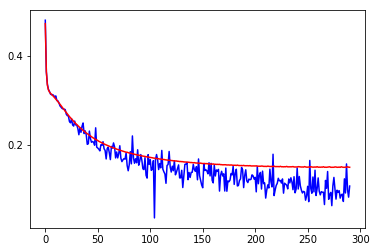

In [30]:
# NO ATTENTION
classifier_nn = MultiLabelClassifier(2048, 512, len(action_labels)).to(device)
train_losses, val_losses = train(classifier_nn, epochs=50, attention='none')
showPlot(train_losses, val_losses)

100 0.2501402795314789 0.2514846622943878
200 0.2196231633424759 0.21345147490501404
300 0.18702831864356995 0.18855956196784973
400 0.1490672528743744 0.17244122922420502
500 0.12194136530160904 0.16285943984985352
600 0.1207602322101593 0.15483786165714264
700 0.10264097154140472 0.15017466247081757
800 0.07890050858259201 0.1454424113035202
900 0.09522467851638794 0.14327161014080048
1000 0.09740094840526581 0.1408235728740692
1100 0.07905905693769455 0.13966335356235504
1200 0.08460452407598495 0.13969099521636963
1300 0.053933821618556976 0.13964205980300903
1400 0.07371391355991364 0.13811782002449036
1500 0.040908392518758774 0.13789844512939453
1600 0.04419539123773575 0.13871702551841736
1700 0.05464484170079231 0.13849985599517822


<Figure size 432x288 with 0 Axes>

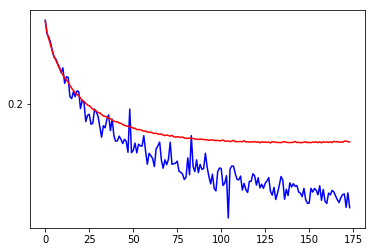

In [51]:
# GAZE ATTENTION
gaze_classifier_nn = MultiLabelClassifier(4096, 512, len(action_labels)).to(device)
train_losses, val_losses = train(gaze_classifier_nn, epochs=30, attention='gaze')
showPlot(train_losses, val_losses)

In [116]:
attSoftmax=nn.Softmax(dim=-1)
# attSoftmax=nn.Sigmoid()

def create_context_batch2(end_idx, image_vectors, model, device, start_idx=0, exact_batch_size=None,
                          manual_attention=None):

    if not exact_batch_size:
        exact_batch_size = end_idx

#     start=time.time()
    contexts = np.zeros((exact_batch_size, 2048))
            
    raw_feature=Variable(torch.FloatTensor(image_vectors[start_idx: start_idx + exact_batch_size, :, : ,: ]).to(device))
#     e = model.attfc(model.att(raw_feature).view(exact_batch_size,-1))
    e = model.att(raw_feature).view(exact_batch_size,-1)
    alpha2 = attSoftmax(e)
#     print(alpha2, torch.max(alpha2, dim=1))
#     alpha2 = torch.div(alpha2, torch.max(alpha2, dim=1)[0].view(-1,1).expand(-1,49))
    if manual_attention is None:
        contexts = torch.bmm(raw_feature.view(exact_batch_size,2048,-1), 
                             alpha2.view(exact_batch_size,-1,1)).view(exact_batch_size,-1).detach().cpu().numpy()
    else:
        contexts = torch.bmm(raw_feature.view(exact_batch_size,2048,-1),
                             manual_attention.view(exact_batch_size,-1,1)).view(exact_batch_size,-1).detach().cpu().numpy()

    
#     end = time.time()
    return contexts, alpha2


100 0.2926272749900818 0.2881157100200653
200 0.2509523928165436 0.24519984424114227
300 0.21663925051689148 0.21863508224487305
400 0.19211314618587494 0.20103299617767334
500 0.16620248556137085 0.18941164016723633
600 0.1626204252243042 0.18003562092781067
700 0.14440646767616272 0.17343439161777496
800 0.12005419284105301 0.16805003583431244
900 0.12972603738307953 0.16423854231834412
1000 0.13315993547439575 0.16106294095516205
1100 0.13460731506347656 0.15860724449157715
1200 0.12879306077957153 0.15725915133953094
1300 0.10286134481430054 0.15530255436897278
1400 0.11876090615987778 0.15406480431556702
1500 0.09212883561849594 0.1528598666191101
1600 0.09776696562767029 0.15226037800312042
1700 0.10970652103424072 0.15088938176631927


<Figure size 432x288 with 0 Axes>

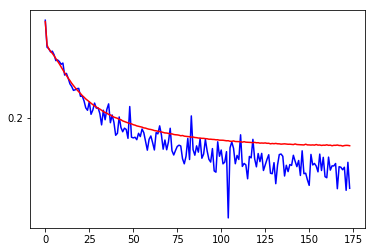

In [119]:
# SELF ATTENTION
self_attention_classifier_nn = MultiLabelClassifier(4096, 512, len(action_labels)).to(device)
train_losses, val_losses = train(self_attention_classifier_nn, epochs=30, attention='self')
showPlot(train_losses, val_losses)

100 0.29580721259117126 0.27800166606903076
200 0.25256848335266113 0.23533406853675842
300 0.2162625640630722 0.20746074616909027
400 0.18345771729946136 0.19036521017551422
500 0.1551719605922699 0.17965185642242432
600 0.15542876720428467 0.17027585208415985
700 0.1364148110151291 0.16485579311847687
800 0.1098962351679802 0.1601225584745407
900 0.12497743219137192 0.15740811824798584
1000 0.13320022821426392 0.1544068455696106
1100 0.12059306353330612 0.15268981456756592
1200 0.12393304705619812 0.15215572714805603
1300 0.09218291938304901 0.15129584074020386
1400 0.10746490210294724 0.14988559484481812
1500 0.079059898853302 0.14919713139533997
1600 0.08264704048633575 0.14955900609493256
1700 0.10296560823917389 0.14904721081256866


<Figure size 432x288 with 0 Axes>

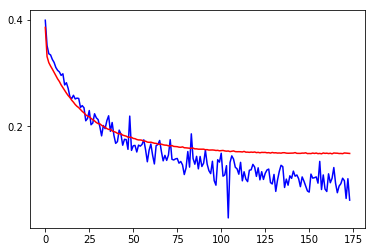

In [118]:
# SELF-GAZE ATTENTION
self_gaze_classifier_nn = MultiLabelClassifier(4096, 512, len(action_labels)).to(device)
train_losses, val_losses = train(self_gaze_classifier_nn, epochs=30, attention='self_gaze',
                                 tf_ratio=0.95,loss_ratio=10)
showPlot(train_losses, val_losses)

# Evaluation

In [120]:
from confusion_matrix import multilabel_confusion_matrix
import sklearn
from scipy.special import softmax
# print('Performance of SVM:')
# print('F1 score: %f'%(sklearn.metrics.f1_score(val_labels_npa,predictions,average='samples')))
# print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(val_labels_npa,predictions)))
# print('AP score: %f'%(sklearn.metrics.average_precision_score(val_labels_npa, predictions)))
# # print('confusion matrix:\n',multilabel_confusion_matrix(val_labels_npa, predictions,labels=range(10)))
# 
# print('Performance of SVM WITH GAZE DATA:')
# print('F1 score: %f'%(sklearn.metrics.f1_score(all_val_labels_npa,gaze_predictions,average='samples')))
# print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(all_val_labels_npa,gaze_predictions)))
# print('AP score: %f'%(sklearn.metrics.average_precision_score(all_val_labels_npa, gaze_predictions)))
# # print('confusion matrix:\n',multilabel_confusion_matrix(val_labels_npa, gaze_predictions,labels=range(10)))

predictions_probabilities = softmax(classifier_nn(torch.stack(validation_input)).detach().cpu().numpy(), axis=1)
predictions_nn_argmax = predictions_probabilities.argmax(axis=1)
predictions_nn = np.zeros((len(val_labels_npa), len(action_labels)))
for i in range(len(val_labels_npa)):
    predictions_nn[i, predictions_nn_argmax[i]] = 1
print('Performance of NN:')
print('F1 score: %f'%(sklearn.metrics.f1_score(val_labels_npa, predictions_nn, average='samples')))
print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(val_labels_npa, predictions_nn)))
print('Overall AP score: %f'%(sklearn.metrics.average_precision_score(val_labels_npa, predictions_probabilities)))
# print('confusion matrix:\\n',multilabel_confusion_matrix(val_labels_npa, predictions_nn,labels=range(10)))
for i in range(10):
    print('AP score - %s: %f'%(action_labels[i], sklearn.metrics.average_precision_score(val_labels_npa[:,i], predictions_probabilities[:,i]) * 100))


predictions_probabilities = softmax(gaze_classifier_nn(torch.stack(gaze_validation_input)).detach().cpu().numpy(), axis=1)
predictions_nn_argmax = predictions_probabilities.argmax(axis=1)
predictions_nn = np.zeros((len(all_val_labels_npa), len(action_labels)))
for i in range(len(all_val_labels_npa)):
    predictions_nn[i, predictions_nn_argmax[i]] = 1
print('Performance of NN WITH GAZE DATA:')
print('F1 score: %f'%(sklearn.metrics.f1_score(all_val_labels_npa, predictions_nn, average='samples')))
print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(all_val_labels_npa, predictions_nn)))
print('Overall AP score: %f'%(sklearn.metrics.average_precision_score(all_val_labels_npa, predictions_probabilities)))
# print('confusion matrix:\\n',multilabel_confusion_matrix(val_labels_npa, predictions_nn,labels=range(10)))
for i in range(10):
    print('AP score - %s: %f'%(action_labels[i], sklearn.metrics.average_precision_score(all_val_labels_npa[:,i], predictions_probabilities[:,i])* 100))

contexts, attetion_maps = create_context_batch2(val_labels_npa.shape[0], image_validation_vectors, self_attention_classifier_nn, device)
attention_input = Variable(torch.FloatTensor(np.hstack((validation_vectors, contexts)))).to(device)
predictions_probabilities = softmax(self_attention_classifier_nn(attention_input).detach().cpu().numpy(), axis=1)
predictions_nn_argmax = predictions_probabilities.argmax(axis=1)
predictions_nn = np.zeros((len(val_labels_npa), len(action_labels)))
for i in range(len(val_labels_npa)):
    predictions_nn[i, predictions_nn_argmax[i]] = 1
print('Performance of NN WITH SELF ATTENTION:')
print('F1 score: %f'%(sklearn.metrics.f1_score(val_labels_npa, predictions_nn, average='samples')))
print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(val_labels_npa, predictions_nn)))
print('Overall AP score: %f'%(sklearn.metrics.average_precision_score(val_labels_npa, predictions_probabilities)))
# print('confusion matrix:\\n',multilabel_confusion_matrix(val_labels_npa, predictions_nn,labels=range(10)))
for i in range(10):
    print('AP score - %s: %f'%(action_labels[i], sklearn.metrics.average_precision_score(val_labels_npa[:,i], predictions_probabilities[:,i]) * 100))
    
contexts, attetion_maps = create_context_batch2(val_labels_npa.shape[0], image_validation_vectors, self_gaze_classifier_nn, device)
self_gaze_input = Variable(torch.FloatTensor(np.hstack((validation_vectors, contexts)))).to(device)
predictions_probabilities = softmax(self_gaze_classifier_nn(self_gaze_input).detach().cpu().numpy(), axis=1)
predictions_nn_argmax = predictions_probabilities.argmax(axis=1)
predictions_nn = np.zeros((len(val_labels_npa), len(action_labels)))
for i in range(len(val_labels_npa)):
    predictions_nn[i, predictions_nn_argmax[i]] = 1
print('Performance of NN WITH SELF GAZE:')
print('F1 score: %f'%(sklearn.metrics.f1_score(val_labels_npa, predictions_nn, average='samples')))
print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(val_labels_npa, predictions_nn)))
print('Overall AP score: %f'%(sklearn.metrics.average_precision_score(val_labels_npa, predictions_probabilities)))
# print('confusion matrix:\\n',multilabel_confusion_matrix(val_labels_npa, predictions_nn,labels=range(10)))
for i in range(10):
    print('AP score - %s: %f'%(action_labels[i], sklearn.metrics.average_precision_score(val_labels_npa[:,i], predictions_probabilities[:,i]) * 100))

Performance of NN:
F1 score: 0.697511
Accuracy score: 0.697511
Overall AP score: 0.756933
AP score - phoning: 69.752446
AP score - playinginstrument: 87.874288
AP score - reading: 64.360890
AP score - ridingbike: 88.889273
AP score - ridinghorse: 91.432043
AP score - running: 76.051002
AP score - takingphoto: 64.746260
AP score - usingcomputer: 85.026495
AP score - walking: 44.370052
AP score - jumping: 84.430742
Performance of NN WITH GAZE DATA:
F1 score: 0.711039
Accuracy score: 0.711039
Overall AP score: 0.791129
AP score - phoning: 77.753930
AP score - playinginstrument: 87.720458
AP score - reading: 69.186803
AP score - ridingbike: 90.102569
AP score - ridinghorse: 91.978135
AP score - running: 75.852015
AP score - takingphoto: 70.803107
AP score - usingcomputer: 85.637055
AP score - walking: 57.313778
AP score - jumping: 84.781621
Performance of NN WITH SELF ATTENTION:
F1 score: 0.685606
Accuracy score: 0.685606
Overall AP score: 0.753700
AP score - phoning: 69.119534
AP score - 

2012_002091
Ground Truth: walking
NN Predicted: running
Gaze NN Predicted: walking
Self Attention NN Predicted: running
Self Gaze NN Predicted: walking


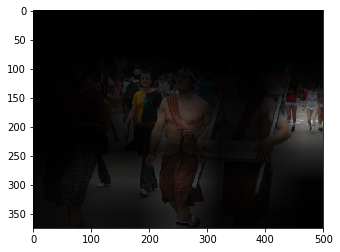

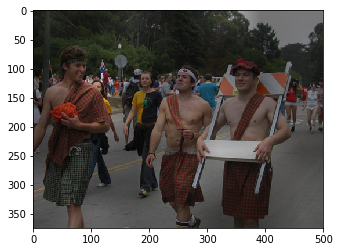

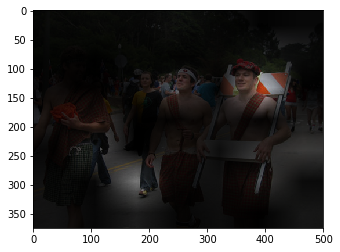

In [85]:
# Check predictions of random image
p = random.randint(0, len(val_labels_npa))
# p=906
print(val_idx_to_imid[p])

# Print out predictions for each model and ground truth
out = softmax(classifier_nn(validation_input[p]).detach().cpu().numpy())
out_gaze = softmax(gaze_classifier_nn(gaze_validation_input[p]).detach().cpu().numpy())
out_self = softmax(self_attention_classifier_nn(attention_input[p]).detach().cpu().numpy())
out_self_gaze = softmax(self_gaze_classifier_nn(self_gaze_input[p]).detach().cpu().numpy())

print('Ground Truth: ' + action_labels[np.argmax(val_labels_npa[p])])
print('NN Predicted: ' + action_labels[np.argmax(out)])
print('Gaze NN Predicted: ' + action_labels[np.argmax(out_gaze)])
print('Self Attention NN Predicted: ' + action_labels[np.argmax(out_self)])
print('Self Gaze NN Predicted: ' + action_labels[np.argmax(out_self_gaze)])

# Plot heat map for gaze-attention and self-attention
iid = val_idx_to_imid[list(val_idx_to_imid)[p]]
img = plt.imread(val_id_to_file[iid])

plt.figure(1)  # Gaze-attention

subject="006_"
exists = os.path.isfile(os.path.join(gaze_dir, subject + iid + '.jpg.txt'))
if exists:
    gaze_data = pd.read_csv(os.path.join(gaze_dir, subject + iid + '.jpg.txt'), delim_whitespace=True, header=None)
else:
    # Use data from subject '006_ as dummy'
    gaze_data = pd.read_csv(os.path.join(gaze_dir, '006_' + iid + '.jpg.txt'), delim_whitespace=True, header=None)
    test_flag[p] = False
# filter S or F
# gaze_data = gaze_data.loc[gaze_data[5] == "F"]
gaze = gaze_data.values[:, 3:5]
gaze = gaze.astype(float)   

gaze_map = create_gaze_map(img, gaze, screen, plot=False)
upsampled_gaze_map = nn.functional.interpolate(torch.tensor(np.array(Image.fromarray(gaze_map).resize((7, 7)))).unsqueeze(0).unsqueeze(0),
                                               size=(img.shape[0], img.shape[1]),
                                               mode='bilinear',
                                               align_corners=False).squeeze(0).squeeze(0).unsqueeze(-1)
plt.imshow(img)
plt.imshow(np.dstack((np.zeros((img.shape[0], img.shape[1], 3)), -(upsampled_gaze_map-1))))

plt.figure(2)  # Self attention
# e = np.zeros((7, 7))
# for row in range(7):
#     for col in range(7):
#         a = Variable(torch.FloatTensor(image_validation_vectors[p, :, row, col])).to(device)
#         e[row, col] = self_attention_classifier_nn.attention(a).detach().cpu().numpy()
# alpha = softmax(e.flatten()).reshape((7, 7))
a=Variable(torch.FloatTensor(image_validation_vectors[p: p + 1, :, : ,: ]).to(device))
e = self_attention_classifier_nn.attfc(self_attention_classifier_nn.att(a).view(1,-1))
alpha = attSoftmax(e).view(7,7).detach().cpu().numpy()


upsampled_gaze_map = nn.functional.interpolate(torch.tensor(alpha/np.max(alpha)).unsqueeze(0).unsqueeze(0),
                                               size=(img.shape[0], img.shape[1]),
                                               mode='bilinear',
                                               align_corners=False).squeeze(0).squeeze(0).unsqueeze(-1)


plt.imshow(img)
plt.imshow(np.dstack((np.zeros((img.shape[0], img.shape[1], 3)), -(upsampled_gaze_map-1))))

plt.figure(3)  # Self gaze
# e = np.zeros((7, 7))
# for row in range(7):
#     for col in range(7):
#         a = Variable(torch.FloatTensor(image_validation_vectors[p, :, row, col])).to(device)
#         e[row, col] = self_gaze_classifier_nn.attention(a).detach().cpu().numpy()
# alpha = softmax(e.flatten()).reshape((7, 7))

a=Variable(torch.FloatTensor(image_validation_vectors[p: p + 1, :, : ,: ]).to(device))
e = self_gaze_classifier_nn.attfc(self_gaze_classifier_nn.att(a).view(1,-1))
alpha = attSoftmax(e).view(7,7).detach().cpu().numpy()

upsampled_gaze_map = nn.functional.interpolate(torch.tensor(alpha/np.max(alpha)).unsqueeze(0).unsqueeze(0),
                                               size=(img.shape[0], img.shape[1]),
                                               mode='bilinear',
                                               align_corners=False).squeeze(0).squeeze(0).unsqueeze(-1)



plt.imshow(img)
plt.imshow(np.dstack((np.zeros((img.shape[0], img.shape[1], 3)), -(upsampled_gaze_map-1))))

# generating testset prediction

In [122]:
def prediction_printer(im_preds, imid_to_idx, p2i, write_to_file=False,
                         prefix="pred/",suffix="_test.txt"):
    
    person_pred = np.zeros((len(p2i),len(action_labels)))
    for i, action in enumerate(action_labels):
        if write_to_file:
            filename = prefix + action + suffix
            f = open(filename,"w")
        
        for pid in p2i:
            iid=p2i[pid]
            if iid[0] in imid_to_idx:
                person_pred[pid,i] = im_preds[imid_to_idx[iid[0]],i]
            if write_to_file:
                f.write("%s  %d  %f\n"%(iid[0],iid[1],
                                         person_pred[pid,i]))
           
        if write_to_file:     
            f.close()
            print("Predictions printed to file: %s"%(filename))
    return person_pred

In [124]:
pred_val_person = prediction_printer(predictions_probabilities, val_imid_to_idx, val_p2i, 
                                      write_to_file=False, prefix="results/VOC2012/Action/comp10_action_val_",
                                      suffix=".txt")
predictions_nn_argmax_person = pred_val_person.argmax(axis=1)
predictions_nn_person = np.zeros((len(val_labels), len(action_labels)))
for i in range(len(val_labels)):
    predictions_nn_person[i, predictions_nn_argmax_person[i]] = 1
print('Performance of NN WITH GAZE DATA by person:')
val_lables_npa_person = np.asanyarray(val_labels)
print('F1 score: %f'%(sklearn.metrics.f1_score(val_lables_npa_person, predictions_nn_person, average='samples')))
print('Accuracy score: %f'%(sklearn.metrics.accuracy_score(val_lables_npa_person, predictions_nn_person)))
print('Overall AP score: %f'%(sklearn.metrics.average_precision_score(val_lables_npa_person, pred_val_person)))
# print('confusion matrix:\\n',multilabel_confusion_matrix(val_labels_npa, predictions_nn,labels=range(10)))
for i in range(10):
    print('AP score - %s: %f'%(action_labels[i], sklearn.metrics.average_precision_score(val_lables_npa_person[:,i], pred_val_person[:,i])))


Performance of NN WITH GAZE DATA by person:
F1 score: 0.548346
Accuracy score: 0.545802
Overall AP score: 0.704956
AP score - phoning: 0.641764
AP score - playinginstrument: 0.828731
AP score - reading: 0.625010
AP score - ridingbike: 0.800321
AP score - ridinghorse: 0.847418
AP score - running: 0.731482
AP score - takingphoto: 0.581808
AP score - usingcomputer: 0.801865
AP score - walking: 0.440652
AP score - jumping: 0.750513


/home/zhangyuchi45/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [81]:

# Construct the validation input
with torch.no_grad():
   test_input = [Variable(torch.FloatTensor(test_vector)).to(device) for test_vector in test_vectors]
   gaze_test_input = [Variable(torch.FloatTensor(test_vector)).to(device) for test_vector in all_gaze_test]

predictions_probabilities_test = softmax(gaze_classifier_nn(torch.stack(gaze_test_input)).detach().cpu().numpy(), axis=1)
pred_test_person = prediction_printer(predictions_probabilities_test, test_imid_to_idx, test_p2i,
                                      write_to_file=True, prefix="results/VOC2012/Action/comp10_action_test_",
                                      suffix=".txt")

Predictions printed to file: results/VOC2012/Action/comp10_action_test_phoning.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_playinginstrument.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_reading.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_ridingbike.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_ridinghorse.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_running.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_takingphoto.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_usingcomputer.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_walking.txt
Predictions printed to file: results/VOC2012/Action/comp10_action_test_jumping.txt


In [30]:
print(p)

906
